In [1]:
from anything_vae import (
    Encoder,
    Decoder,
)

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.models import vgg16
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchvision import transforms, models as torchvision_models
from pytorch_lightning import LightningModule, Trainer, loggers, callbacks
# import pytorch_lightning as pl
from torchmetrics import MeanSquaredError
from PIL import Image

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
from collections import deque
import heapq
from sklearn.cluster import KMeans
import re
import torchvision.transforms as transforms
import json

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def extract_dominant_colors(image, num_colors=100, num_samples=10000):
    """
    Extract dominant colors from an image using random sampling.
    
    Args:
        image (PIL.Image): Input image
        num_colors (int): Number of colors to extract
        num_samples (int): Number of pixels to sample
        
    Returns:
        torch.Tensor: Tensor of shape (num_colors, 3) containing RGB values
    """
    # Convert image to numpy array
    img_array = np.array(image)
    
    # Reshape the array to 2D (pixel_count, 3)
    pixels = img_array.reshape(-1, 3)
    
    # Random sampling
    total_pixels = pixels.shape[0]
    if total_pixels > num_samples:
        indices = np.random.choice(total_pixels, num_samples, replace=False)
        pixels = pixels[indices]
    
    # Round colors to reduce similar shades
    pixels = np.round(pixels / 255 * 32) * (255 / 32)
    
    # Get unique colors and their counts
    unique_colors, counts = np.unique(pixels, axis=0, return_counts=True)
    
    # Sort by frequency
    sorted_indices = np.argsort(-counts)
    sorted_colors = unique_colors[sorted_indices]
    
    # Take top num_colors
    top_colors = sorted_colors[:num_colors]
    
    # Pad if we don't have enough unique colors
    if len(top_colors) < num_colors:
        padding = np.tile(top_colors[-1], (num_colors - len(top_colors), 1))
        top_colors = np.vstack((top_colors, padding))
    
    # Convert to tensor and normalize to [0, 1]
    color_tensor = torch.FloatTensor(top_colors) / 255.0
    
    return color_tensor

class ColorizationDataset(Dataset):
    def __init__(self, data_folder, data_csv, cache_dir='color_hints_cache', transform=None, hint_offset=3, num_colors=100):
        """
        Args:
            data_folder (string): Directory with all the images.
            data_csv (string): CSV file with image paths.
            cache_dir (string): Directory to store color hints cache.
            transform (callable, optional): Optional transform to be applied on a sample.
            hint_offset (int): Number of images away to fetch the hint image.
            num_colors (int): Number of dominant colors to extract from each image.
        """
        self.data_folder = data_folder
        self.data_path = os.path.join(data_folder, data_csv)
        self.images = pd.read_csv(self.data_path)
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor()
        ])
        self.tranform_output = transforms.Compose([transforms.ToTensor()])
        self.hint_offset = hint_offset
        self.num_colors = num_colors
        
        # Setup cache directory and file
        self.cache_dir = cache_dir
        os.makedirs(cache_dir, exist_ok=True)
        self.cache_file = os.path.join(cache_dir, f'color_hints_{num_colors}_colors.json')
        
        # Load existing cache or create new one
        self.color_hints_cache = self._load_cache()
        self.cache_updates = 0  # Counter for tracking updates
        
        # Extract show names from the file paths
        self.images['show'] = self.images['Sketch Path'].apply(
            lambda x: os.path.basename(os.path.dirname(x))
        )
        # Sort the DataFrame by show to group images from the same show
        self.images = self.images.sort_values(by=['show']).reset_index(drop=True)

    def _load_cache(self):
        """Load color hints cache from disk"""
        if os.path.exists(self.cache_file):
            with open(self.cache_file, 'r') as f:
                try:
                    cache_dict = json.load(f)
                    # Convert stored lists back to tensors
                    return {k: torch.tensor(v, dtype=torch.float32) for k, v in cache_dict.items()}
                except json.JSONDecodeError:
                    print(f"Warning: Cache file {self.cache_file} is corrupted. Creating new cache.")
                    return {}
        return {}

    def _save_cache(self):
        """Save color hints cache to disk"""
        # Convert tensors to lists for JSON serialization
        cache_dict = {k: v.tolist() for k, v in self.color_hints_cache.items()}
        temp_file = self.cache_file + '.tmp'
        try:
            with open(temp_file, 'w') as f:
                json.dump(cache_dict, f)
            os.replace(temp_file, self.cache_file)  # Atomic write
        except Exception as e:
            print(f"Error saving cache: {str(e)}")
            if os.path.exists(temp_file):
                os.remove(temp_file)

    def _get_or_extract_color_hints(self, colored_path):
        """Get color hints from cache or extract them"""
        if colored_path not in self.color_hints_cache:
            colored_pil = self.__loadImage(colored_path)
            color_hints = extract_dominant_colors(colored_pil, self.num_colors)
            self.color_hints_cache[colored_path] = color_hints
            
            # Save to disk every 1000 new extractions
            self.cache_updates += 1
            if self.cache_updates % 1000 == 0:
                print(f"Saving cache after {self.cache_updates} updates...")
                self._save_cache()
                
        return self.color_hints_cache[colored_path]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        row = self.images.iloc[idx]
        sketch = row['Sketch Path']
        colored = row['Frame Path']
        show = row['show']
        
        # Get indices of all images from the same show
        show_indices = self.images.index[self.images['show'] == show].tolist()
        pos_in_show = show_indices.index(idx)
        hint_pos_in_show = pos_in_show + self.hint_offset
        hint_pos_in_show = max(0, min(hint_pos_in_show, len(show_indices) - 1))
        hint_idx = show_indices[hint_pos_in_show]
        hint_row = self.images.iloc[hint_idx]
        hint_sketch = hint_row['Sketch Path']
        hint_colored = hint_row['Frame Path']
        
        # Load images
        sketch_image = self.transform(self.__loadImage(sketch))
        colored_image = self.tranform_output(self.__loadImage(colored))
        hint_image = self.tranform_output(self.__loadImage(hint_colored))
        
        # Get color hints using cache
        color_hints = self._get_or_extract_color_hints(colored)
            
        return sketch_image, colored_image, color_hints, hint_image

    def viewImage(self, idx):
        sketch, colored = self.images.iloc[idx][['Sketch Path', 'Frame Path']]
        return self.__loadImage(sketch), self.__loadImage(colored)
    
    def __loadImage(self, image_path):
        return Image.open(os.path.join(self.data_folder, image_path))
    
    def get_color_hints(self, idx):
        """Get color hints for a specific image index without loading the full data item."""
        row = self.images.iloc[idx]
        colored = row['Frame Path']
        return self._get_or_extract_color_hints(colored)

    def __del__(self):
        """Save cache when the dataset object is destroyed"""
        self._save_cache()

In [3]:
data_folder = 'data/training'
data_csv = 'data.csv'
training_dataset = ColorizationDataset(data_folder, data_csv)

In [4]:
class VGGPerceptualLoss(LightningModule):
    def __init__(self, vgg_model):
        super().__init__()
        self.vgg = vgg_model
        self.criterion = nn.MSELoss()
        self.features = list(self.vgg.features[:16])
        self.features = nn.Sequential(*self.features).eval()
        
        for params in self.features.parameters():
            params.requires_grad = False

    def forward(self, x, y):
        return self.criterion(self.features(x),self.features(y))

In [5]:
class ColorHintEmbedding(nn.Module):
    def __init__(self, n_colors=50, color_dim=3, embed_dim=256):
        super().__init__()
        self.color_embedding = nn.Linear(color_dim, embed_dim)
        self.norm = nn.LayerNorm(embed_dim)
        
    def forward(self, colors, positions=None):  # positions parameter kept for backward compatibility
        # colors: [batch_size, n_colors, 3]
        b, n, _ = colors.shape
        color_embed = self.color_embedding(colors)  # [b, n, embed_dim]
        return self.norm(color_embed)

class ReferenceImageEncoder(nn.Module):
    def __init__(self, transformer_dim=256):
        super().__init__()
        # Reduce initial channels and add more aggressive pooling
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  # Stride=2 reduces spatial dim
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # Further reduction
            nn.ReLU(),
            nn.Conv2d(64, transformer_dim, 3, stride=2, padding=1),  # Final reduction
            nn.ReLU()
        )
        self.norm = nn.GroupNorm(8, transformer_dim)
        
        # Add adaptive pooling to ensure consistent output size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((16, 16))  # Fixed output size
        
    def forward(self, ref_image):
        features = self.conv_blocks(ref_image)
        features = self.norm(features)
        features = self.adaptive_pool(features)  # Ensure consistent spatial dims
        return features
class SelfAttention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        
        self.dim_head = 32
        self.hidden_dim = self.dim_head * heads
        
        self.to_q = nn.Conv2d(dim, self.hidden_dim, 1, bias=False)
        self.to_k = nn.Conv2d(dim, self.hidden_dim, 1, bias=False)
        self.to_v = nn.Conv2d(dim, self.hidden_dim, 1, bias=False)
        
        # Add linear projections for non-spatial inputs
        self.to_k_linear = nn.Linear(dim, self.hidden_dim)
        self.to_v_linear = nn.Linear(dim, self.hidden_dim)
        
        self.to_out = nn.Sequential(
            nn.Conv2d(self.hidden_dim, dim, 1),
            nn.Dropout(0.1)
        )

    def forward(self, x, context=None):
        b, c, h, w = x.shape
        
        if context is not None:
            # Handle non-spatial context (color hints)
            if len(context.shape) == 3:  # [batch, n_colors, dim]
                q = self.to_q(x)  # [b, hidden_dim, h, w]
                k = self.to_k_linear(context)  # [b, n_colors, hidden_dim]
                v = self.to_v_linear(context)  # [b, n_colors, hidden_dim]
                
                # Reshape query to [b, heads, h*w, dim_head]
                q = q.reshape(b, self.heads, self.dim_head, h * w).transpose(-2, -1)
                
                # Reshape key and value to [b, heads, n_colors, dim_head]
                k = k.reshape(b, -1, self.heads, self.dim_head).transpose(1, 2)
                v = v.reshape(b, -1, self.heads, self.dim_head).transpose(1, 2)
                
            else:
                # Handle spatial context (reference image)
                if context.shape[-2:] != (h, w):
                    context = F.interpolate(context, size=(h, w), mode='bilinear', align_corners=False)
                
                q = self.to_q(x)
                k = self.to_k(context)
                v = self.to_v(context)
                
                # Reshape to [b, heads, h*w, dim_head]
                q = q.reshape(b, self.heads, self.dim_head, -1).transpose(-2, -1)
                k = k.reshape(b, self.heads, self.dim_head, -1).transpose(-2, -1)
                v = v.reshape(b, self.heads, self.dim_head, -1).transpose(-2, -1)
        else:
            q = self.to_q(x)
            k = self.to_k(x)
            v = self.to_v(x)
            
            # Reshape to [b, heads, h*w, dim_head]
            q = q.reshape(b, self.heads, self.dim_head, -1).transpose(-2, -1)
            k = k.reshape(b, self.heads, self.dim_head, -1).transpose(-2, -1)
            v = v.reshape(b, self.heads, self.dim_head, -1).transpose(-2, -1)
        
        # Attention
        dots = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        dots = dots - dots.max(dim=-1, keepdim=True)[0]
        attn = dots.softmax(dim=-1)
        
        # Apply attention and reshape
        out = torch.matmul(attn, v)
        out = out.transpose(-2, -1).reshape(b, -1, h, w)
        
        return self.to_out(out)

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.attention = SelfAttention(dim, heads)
        self.color_cross_attn = SelfAttention(dim, heads)
        self.ref_cross_attn = SelfAttention(dim, heads)
        
        self.norm1 = nn.GroupNorm(8, dim)
        self.norm2 = nn.GroupNorm(8, dim)
        self.norm_color = nn.GroupNorm(8, dim)
        self.norm_ref = nn.GroupNorm(8, dim)
        
        self.ffn = nn.Sequential(
            nn.Conv2d(dim, dim * 4, 1),
            nn.GELU(),
            nn.Conv2d(dim * 4, dim, 1)
        )

    def forward(self, x, color_hints=None, ref_features=None):
        # Self-attention
        x = x + self.attention(self.norm1(x))
        
        # Cross-attention with color hints if provided
        if color_hints is not None:
            x = x + self.color_cross_attn(self.norm_color(x), color_hints)
            
        # Cross-attention with reference image features if provided
        if ref_features is not None:
            x = x + self.ref_cross_attn(self.norm_ref(x), ref_features)
        
        # FFN
        x = x + self.ffn(self.norm2(x))
        return x

In [6]:
class Colorizer(LightningModule):
    def __init__(self, checkpoint_path=None, transformer_dim=256, transformer_heads=8):
        super(Colorizer, self).__init__()
        
        if checkpoint_path is not None:
            checkpoint = torch.load(checkpoint_path, map_location='cpu')
            
            self.encoder = Encoder()
            self.decoder = Decoder()
            self.quant_conv = nn.Conv2d(8, 8, kernel_size=1)
            self.post_quant_conv = nn.Conv2d(4, 4, kernel_size=1)
            
            self.encoder.load_state_dict(
                {k.replace('encoder.', ''): v for k, v in checkpoint['state_dict'].items() if k.startswith('encoder.')}
            )
            self.decoder.load_state_dict(
                {k.replace('decoder.', ''): v for k, v in checkpoint['state_dict'].items() if k.startswith('decoder.')}
            )
            self.quant_conv.load_state_dict(
                {k.replace('quant_conv.', ''): v for k, v in checkpoint['state_dict'].items() if k.startswith('quant_conv.')}
            )
            self.post_quant_conv.load_state_dict(
                {k.replace('post_quant_conv.', ''): v for k, v in checkpoint['state_dict'].items() if k.startswith('post_quant_conv.')}
            )
            
            vgg_model = vgg16(weights=True)
            self.loss_fn = VGGPerceptualLoss(vgg_model)
            self.mse_loss_fn = nn.MSELoss()
            
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False
            for param in self.quant_conv.parameters():
                param.requires_grad = False
            for param in self.post_quant_conv.parameters():
                param.requires_grad = False
                
            print("Loaded pretrained weights from checkpoint")
        else:
            self.encoder = Encoder()
            self.decoder = Decoder()
            self.quant_conv = nn.Conv2d(8, 8, kernel_size=1)
            self.post_quant_conv = nn.Conv2d(4, 4, kernel_size=1)
            vgg_model = vgg16(weights=True)
            self.loss_fn = VGGPerceptualLoss(vgg_model)
            self.mse_loss_fn = nn.MSELoss()
            print("Initialized new model from scratch")
        
        # Initialize transformer and hint processing components
        self.to_transformer_dim = nn.Conv2d(4, transformer_dim, 1)
        self.transformer = TransformerBlock(transformer_dim, transformer_heads)
        self.from_transformer_dim = nn.Conv2d(transformer_dim, 4, 1)
        
        # Add color hint and reference image processing
        self.color_hint_processor = ColorHintEmbedding(
            n_colors=50,
            color_dim=3,
            embed_dim=transformer_dim
        )
        self.ref_image_encoder = ReferenceImageEncoder(transformer_dim)
        
        # Training monitoring
        self.num_high_loss_images = 50
        self.high_loss_heap = []
        self.current_min_high_loss = 0
        
        self.hparams.learning_rate = 0.0001

    
    def _freeze_autoencoder(self):
        """Freeze the autoencoder components."""
        components_to_freeze = [
            self.encoder,
            self.decoder,
            self.quant_conv,
            self.post_quant_conv
        ]
        
        for component in components_to_freeze:
            for param in component.parameters():
                param.requires_grad = False
        print("Autoencoder components frozen")
    
    @classmethod
    def load_from_checkpoint(
        cls,
        checkpoint_path,
        map_location=None,
        strict=False,  # Changed to False by default
        **kwargs
    ):
        """
        Custom load_from_checkpoint to handle freezing after loading and skip position embeddings.
        """
        # Load the checkpoint using parent class method
        checkpoint = torch.load(checkpoint_path, map_location=map_location)
        
        # Remove position embedding from state dict
        state_dict = checkpoint['state_dict']
        position_keys = [k for k in state_dict.keys() if 'position_embedding' in k]
        for k in position_keys:
            del state_dict[k]
        
        # Create model instance
        model = super(Colorizer, cls).load_from_checkpoint(
            checkpoint_path,
            map_location=map_location,
            strict=False,  # Use non-strict loading
            **kwargs
        )
        
        # Check if freeze_autoencoder is in hparams and apply freezing
        if hasattr(model.hparams, 'freeze_autoencoder') and model.hparams.freeze_autoencoder:
            model._freeze_autoencoder()
        
        return model

    
    def configure_optimizers(self):
        # Only include trainable parameters
        trainable_params = [p for p in self.parameters() if p.requires_grad]
        return torch.optim.Adam(trainable_params, lr=self.hparams.learning_rate)
        
        return model

    def encode(self, x):
        h = self.encoder(x)
        h = self.quant_conv(h)
        mean, logvar = torch.chunk(h, 2, dim=1)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + std * eps
        return z

    def decode(self, z, color_hints=None, ref_image=None):
        z = self.post_quant_conv(z)
        z = self.to_transformer_dim(z)
        
        # Process hints if provided
        color_features = None
        ref_features = None
        
        if color_hints is not None:
            color_features = self.color_hint_processor(color_hints)
            
        if ref_image is not None:
            ref_features = self.ref_image_encoder(ref_image)

        z = self.transformer(z, color_features, ref_features)
        
        z = self.from_transformer_dim(z)
        x_recon = self.decoder(z)
        return x_recon

    def forward(self, x, color_hints=None, ref_image=None):
        z = self.encode(x)
        x_recon = self.decode(z, color_hints, ref_image)
        return x_recon

    def training_step(self, batch, batch_idx):
        # Simplified batch handling
        if len(batch) == 2:
            inputs, targets = batch
            color_hints = None
            ref_image = None
        elif len(batch) == 3:
            inputs, targets, ref_image = batch
            color_hints = None
        else:
            inputs, targets, color_hints, ref_image = batch
        
        outputs = self(inputs, color_hints, ref_image)
        
        perceptual_loss = self.loss_fn(outputs, targets)
        mse_loss = self.mse_loss_fn(outputs, targets)
        total_loss = perceptual_loss + (mse_loss * 10)
        
        # Store high loss images with reference image and color hints
        self.store_high_loss_image(total_loss, inputs, targets, outputs, ref_image, color_hints)
        
        # Logging
        self.log('train_loss', total_loss)
        self.log('perceptual_loss', perceptual_loss)
        self.log('mse_loss', mse_loss)
        
        # Visualization logic
        if batch_idx % 500 == 0:
            # Visualize samples
            num_images = min(4, inputs.shape[0])
            for i in range(num_images):
                # Create the main grid with input, output, target, and reference
                grid = self.visualize_single_output(
                    inputs[i],
                    outputs[i],
                    targets[i],
                    ref_image[i] if ref_image is not None else None
                )
                
                # Add color palette if color hints are present
                if color_hints is not None:
                    color_grid = self.visualize_color_hints(color_hints[i:i+1])
                    if color_grid is not None:
                        # Ensure color grid has same width as main grid
                        target_width = grid.shape[2]
                        color_height = int(color_grid.shape[1] * (target_width / color_grid.shape[2]))
                        color_grid = F.interpolate(
                            color_grid.unsqueeze(0), 
                            size=(color_height, target_width), 
                            mode='nearest'
                        ).squeeze(0)
                        
                        # Concatenate vertically
                        grid = torch.cat([grid, color_grid], dim=1)
                
                self.logger.experiment.add_image(
                    f'Sample_Images/sample_{i+1}',
                    grid,
                    self.global_step
                )
            
            # Visualize high loss images
            self.visualize_high_loss_images(self.logger, self.global_step)
        
        return total_loss


    def store_high_loss_image(self, loss, inputs, targets, outputs, ref_image=None, color_hints=None):
        """Store high loss images with reference image and color hints"""
        # Convert to CPU and detach from computation graph
        cpu_data = {
            'loss': loss.item(),
            'inputs': inputs.detach().cpu(),
            'targets': targets.detach().cpu(),
            'outputs': outputs.detach().cpu(),
            'ref_image': ref_image.detach().cpu() if ref_image is not None else None,
            'color_hints': color_hints.detach().cpu() if color_hints is not None else None
        }
        
        if len(self.high_loss_heap) < self.num_high_loss_images:
            heapq.heappush(self.high_loss_heap, (loss.item(), cpu_data))
            self.current_min_high_loss = min(loss.item(), self.current_min_high_loss if self.high_loss_heap else float('inf'))
        elif loss.item() > self.current_min_high_loss:
            heapq.heapreplace(self.high_loss_heap, (loss.item(), cpu_data))
            self.current_min_high_loss = self.high_loss_heap[0][0]

    def visualize_high_loss_images(self, logger, step):
        """Visualize stored high loss images with reference images and color hints"""
        if not self.high_loss_heap:
            return
            
        # Sort by loss in descending order
        sorted_entries = sorted(self.high_loss_heap, key=lambda x: x[0], reverse=True)
        
        # Log each high-loss image separately
        for idx, (loss_value, data) in enumerate(sorted_entries):
            # Create main grid with images
            grid = self.visualize_single_output(
                data['inputs'],
                data['outputs'],
                data['targets'],
                data['ref_image']
            )
            
            # Add color palette if available
            if data['color_hints'] is not None:
                color_grid = self.visualize_color_hints(data['color_hints'])
                if color_grid is not None:
                    # Ensure color grid has same width as main grid
                    target_width = grid.shape[2]
                    color_height = int(color_grid.shape[1] * (target_width / color_grid.shape[2]))
                    color_grid = F.interpolate(
                        color_grid.unsqueeze(0), 
                        size=(color_height, target_width), 
                        mode='nearest'
                    ).squeeze(0)
                    
                    # Concatenate vertically
                    grid = torch.cat([grid, color_grid], dim=1)
            
            logger.experiment.add_image(
                f'High_Loss_Images/image_{idx}',
                grid,
                step
            )


    def visualize_single_output(self, input_img, output_img, target_img, ref_image=None):
        """Helper function to create a grid with reference image if available"""
        # Ensure we're working with batched images
        if input_img.dim() == 3:
            input_img = input_img.unsqueeze(0)
            output_img = output_img.unsqueeze(0)
            target_img = target_img.unsqueeze(0)
            if ref_image is not None:
                ref_image = ref_image.unsqueeze(0)
        
        # Create row with input, output, target, and reference image if available
        images = [input_img, output_img, target_img]
        if ref_image is not None:
            images.append(ref_image)
            
        # Concatenate all images
        row = torch.cat(images, dim=0)
        
        # Handle grayscale images
        if row.shape[1] == 1:
            row = row.repeat(1, 3, 1, 1)
            
        # Create grid with all images side by side
        nrow = 4 if ref_image is not None else 3
        grid = torchvision.utils.make_grid(row, nrow=nrow, normalize=True, padding=2)
        return grid
        
    def visualize_color_hints(self, color_hints, size=64):
        """
        Visualize color hints as a palette grid
        Args:
            color_hints: tensor of shape [batch_size, n_colors, 3] with values in range [0,1]
            size: size of each color square in pixels
        Returns:
            grid: tensor of shape [3, H, W] representing the color palette grid
        """
        if color_hints is None:
            return None
            
        batch_size, n_colors, _ = color_hints.shape
        
        # Create square patches for each color
        patches = []
        for b in range(batch_size):
            # Create a row of color patches for this batch
            batch_patches = []
            for c in range(n_colors):
                # Create a square patch of the current color
                color = color_hints[b, c]
                patch = color.view(3, 1, 1).repeat(1, size, size)
                batch_patches.append(patch)
            
            # Stack patches horizontally for this batch
            row = torch.cat(batch_patches, dim=2)
            patches.append(row)
        
        # Stack all batches vertically
        grid = torch.cat(patches, dim=1)
        
        return grid



In [7]:
# chkpt_file = 'checkpoints/version_16.ckpt'
# model = Colorizer(chkpt_file)

In [8]:
chkpt_file = 'checkpoints/color-hints-3-eporchs.ckpt'
model = Colorizer.load_from_checkpoint(chkpt_file)

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initialized new model from scratch


In [9]:
# data_folder = 'data/toy'
data_folder = 'data/training'
data_csv = 'data.csv'
training_dataset = ColorizationDataset(data_folder, data_csv)
dataloader = DataLoader(training_dataset, batch_size=1, shuffle=True, num_workers=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# logger = loggers.TensorBoardLogger("tb_logs", name='color-hint-frozen-vae-transformer')
# trainer = Trainer(accelerator="gpu", devices=1, max_epochs=20, logger=logger, log_every_n_steps=2)

In [11]:
# trainer.fit(model, dataloader)

In [12]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def viewTensor(output):
    image = to_pil_image(output.squeeze())

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

In [13]:
model.eval()
data_folder = 'data/test'
data_csv = 'data.csv'
test_dataset = ColorizationDataset(data_folder, data_csv)
model.cpu()

Colorizer(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
  

In [41]:
idx = 2342
sketch_image, colored_image, color_hints, hint_image = test_dataset[idx]
output = model(sketch_image.unsqueeze(0))

In [56]:
color_hints.unsqueeze(0)

torch.Size([1, 100, 3])

In [57]:
model(sketch_image.unsqueeze(0), color_hints.unsqueeze(0))

tensor([[[[0.3538, 0.3562, 0.3532,  ..., 0.3339, 0.3371, 0.3530],
          [0.3691, 0.3580, 0.3562,  ..., 0.3358, 0.3349, 0.3424],
          [0.3682, 0.3602, 0.3574,  ..., 0.3371, 0.3396, 0.3498],
          ...,
          [0.8651, 0.8710, 0.8791,  ..., 0.8389, 0.8377, 0.8414],
          [0.8680, 0.8814, 0.8672,  ..., 0.8346, 0.8379, 0.8725],
          [0.8421, 0.8890, 0.8837,  ..., 0.8431, 0.8548, 0.7950]],

         [[0.3580, 0.3611, 0.3649,  ..., 0.3452, 0.3566, 0.3295],
          [0.3638, 0.3673, 0.3709,  ..., 0.3498, 0.3543, 0.3497],
          [0.3685, 0.3710, 0.3721,  ..., 0.3563, 0.3622, 0.3642],
          ...,
          [0.8906, 0.9036, 0.9069,  ..., 0.8672, 0.8620, 0.8453],
          [0.8870, 0.9003, 0.9058,  ..., 0.8705, 0.8624, 0.8839],
          [0.8727, 0.9069, 0.9160,  ..., 0.8660, 0.8650, 0.8056]],

         [[0.3882, 0.4127, 0.4093,  ..., 0.3886, 0.3963, 0.3641],
          [0.4126, 0.4327, 0.4244,  ..., 0.4023, 0.4117, 0.3977],
          [0.4170, 0.4305, 0.4238,  ..., 0

In [58]:
def viewImage(dataset, index):
    sketch_image, colored_image, color_hints, hint_image = dataset[index]
    output = model(sketch_image.unsqueeze(0))
    output_tensor = output.squeeze(0)
    viewTensor(visualize_single_output(sketch_image, output_tensor, colored_image))

In [61]:
def viewImageWithHints(dataset, index):
    sketch_image, colored_image, color_hints, hint_image = dataset[index]
    output = model(sketch_image.unsqueeze(0), color_hints.unsqueeze(0))
    output_tensor = output.squeeze(0)
    viewTensor(visualize_single_output(sketch_image, output_tensor, colored_image))

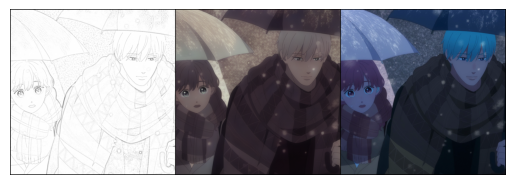

In [59]:
viewImage(test_dataset, 827)

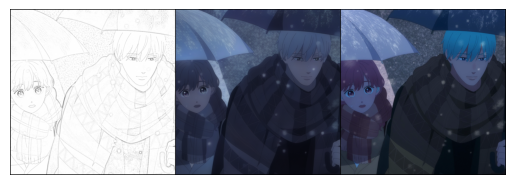

In [64]:
viewImageWithHints(test_dataset, 827)

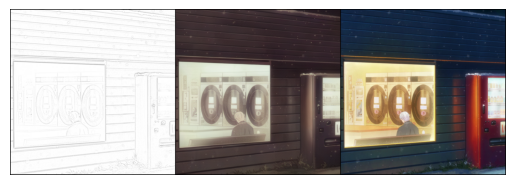

In [50]:
viewImage(test_dataset, 382)

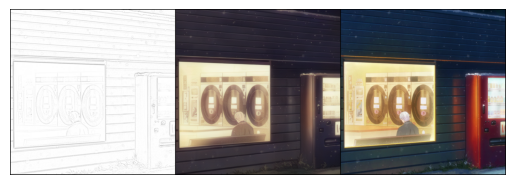

In [65]:
viewImageWithHints(test_dataset, 382)

In [42]:
output_tensor = output.squeeze(0)

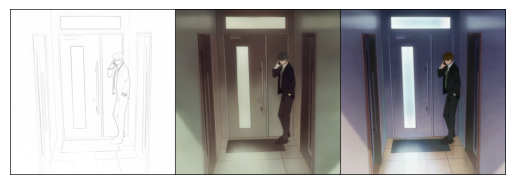

In [46]:
viewTensor(visualize_single_output(sketch_image, output_tensor, colored_image))

In [24]:
hints

ValueError: not enough values to unpack (expected 3, got 2)

In [20]:
def visualize_single_output(input_img, output_img, target_img, ref_image=None):
    """Helper function to create a grid with reference image if available"""
    # Ensure we're working with batched images
    if input_img.dim() == 3:
        input_img = input_img.unsqueeze(0)
        output_img = output_img.unsqueeze(0)
        target_img = target_img.unsqueeze(0)
        if ref_image is not None:
            ref_image = ref_image.unsqueeze(0)
    
    # Create row with input, output, target, and reference image if available
    images = [input_img, output_img, target_img]
    if ref_image is not None:
        images.append(ref_image)
        
    # Concatenate all images
    row = torch.cat(images, dim=0)
    
    # Handle grayscale images
    if row.shape[1] == 1:
        row = row.repeat(1, 3, 1, 1)
        
    # Create grid with all images side by side
    nrow = 4 if ref_image is not None else 3
    grid = torchvision.utils.make_grid(row, nrow=nrow, normalize=True, padding=2)
    return grid
        
def visualize_color_hints(color_hints, size=64):
    """
    Visualize color hints as a palette grid
    Args:
        color_hints: tensor of shape [batch_size, n_colors, 3] with values in range [0,1]
        size: size of each color square in pixels
    Returns:
        grid: tensor of shape [3, H, W] representing the color palette grid
    """
    if color_hints is None:
        return None
        
    batch_size, n_colors, _ = color_hints.shape
    
    # Create square patches for each color
    patches = []
    for b in range(batch_size):
        # Create a row of color patches for this batch
        batch_patches = []
        for c in range(n_colors):
            # Create a square patch of the current color
            color = color_hints[b, c]
            patch = color.view(3, 1, 1).repeat(1, size, size)
            batch_patches.append(patch)
        
        # Stack patches horizontally for this batch
        row = torch.cat(batch_patches, dim=2)
        patches.append(row)
    
    # Stack all batches vertically
    grid = torch.cat(patches, dim=1)
    
    return grid



In [ ]:
viewTensor(y)